# Least-squares fitting in log space with negative values due to background subtraction and noise

Common astronomy situation (and presumably lots of other fields too) for fitting a model to data:
1. Measurements have a background that needs to be subtracted.
2. Measurements have noise.
3. Values span several orders of magnitude, so fits should be done in log-space so that the high values don't overweight the fit.

The problem is that 1 + 2 can lead to negative values, and we can't take the logarithm of those. So how to correctly incorporate them in the fit?

Here is a relatively simple solution that is fundamentally based on a least squares fit, but with modifications for those data points.

## Derivation of least squares from maximum likelihood

We start with some data points $\{\psi_i\}$ with associated uncertainties $\{\Sigma_i\}$. We want to fit a model that predicts that those values for a given set of parameters are $\{\bar{\psi}_i\}$.

If we are transforming into log$_{10}$ space, the new values are
$$ y_i = \log_{10}(\psi_i) $$
with uncertainties
$$ \sigma_i = \frac{\Sigma_i}{\psi_i \ln(10)} $$
(you can of course use any other base for the logarithm and it won't change anything, but as astronomers we often have log$_{10}$ values sitting around anyway, so might as well use them).

Least squares fitting comes from maximizing the likelihood
$$ \mathcal{L} = \prod_i P_i $$
where the probability for each point $i$ is assumed to come from the normal distribution:
$$ P_i = \frac{1}{\sqrt{2\pi} \sigma_i} \exp\left[ -\frac{(y_i - \bar{y}_i)^2}{2 \sigma_i^2} \right] $$
Maximizing $\mathcal{L}$ is equivalent to maximizing $\ln(\mathcal{L})$, which is
$$ \ln(\mathcal{L}) = \sum_i \ln P_i $$
$$ = \sum_i -\frac{(y_i - \bar{y}_i)^2}{2 \sigma_i^2} - \frac{1}{2} \ln(2\pi) - \ln \sigma_i $$

When we do the maximization, the only thing that changes are the model values $\{\bar{y}_i\}$, so the first term is the only one that matters. Maximizing $\ln \mathcal{L}$ is therefore equivalent to minimizing $-\ln \mathcal{L}$ or minimizing the squares of the differences scaled by the uncertainty (since the constant factor of 2 doesn't matter to the minimiziation)
$$ \textrm{Minimize} \qquad \frac{(y_i - \bar{y}_i)^2}{\sigma_i^2} $$

## Modification for negative data points

Since this won't work for the negative values, let's go back to the linear case to reconsider what it means. It is actually an upper limit -- the true value was less than the uncertainty, and so background subtraction was able to make it negative. What is the probability of that occurring, if the true value is given by the model value $\bar{\psi}_i$?

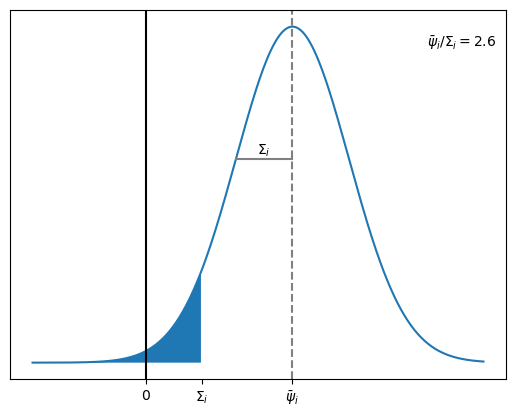

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling.functional_models import Gaussian1D

def plot_shaded_gauss(mean, sig):
    gmodel = Gaussian1D(amplitude=1., mean=mean, stddev=sig)

    psax = np.arange(-2,6,0.02)
    gauss = gmodel(psax)
    psax2 = np.arange(-2,sig,0.02)
    gauss2 = gmodel(psax2)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(psax, gauss)
    ax.fill_between(psax2, gauss2)
    ax.set_xticks([0,sig, mean], ['0','$\\Sigma_i$','$\\bar{\\psi}_i$'])
    ax.set_yticks([])
    ax.axvline(x=0, color='black')
    ax.axvline(x=mean, color='gray', linestyle='dashed')
    sigheight = np.exp(-0.5)
    ax.plot([mean-sig,mean], [sigheight,sigheight], color='gray')
    ax.text(mean-0.5*sig, sigheight, '$\\Sigma_i$', ha='center', va='bottom')
    ax.text(0.98, 0.9, '$\\bar{\\psi}_i / \\Sigma_i = $'+f'{mean/sig}', transform=ax.transAxes, ha='right')
    
plot_shaded_gauss(2.6, 1.)

The amount of shading depends on the ratio $\bar{\psi}_i / \Sigma_i$. If it is small (the predicted value from the model is "not very many sigmas away" from zero), it can be quite high:

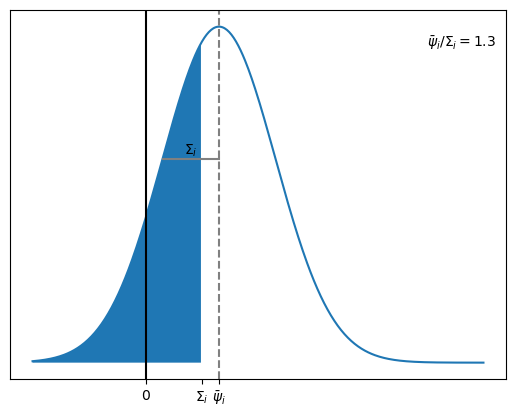

In [2]:
plot_shaded_gauss(1.3,1.)

Or if the model is "many sigmas away from zero", it can be very low.

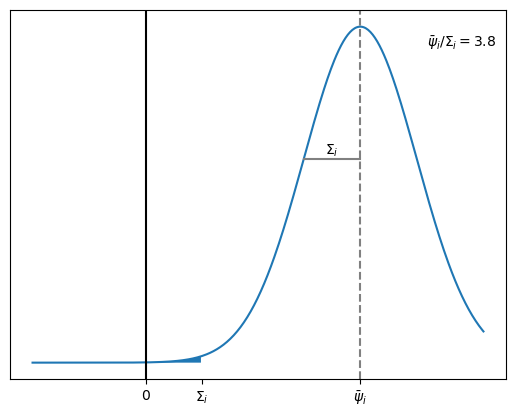

In [3]:
plot_shaded_gauss(3.8, 1.)

We can calculate the area, and therefore the probability, as
$$ P_i = \int_{-\infty}^{\Sigma_i} \mathcal{N}(\psi; \bar{\psi}_i, \Sigma_i)\, d\psi $$
$$ = \frac{1}{\sqrt{2\pi} \Sigma_i} \int_{-\infty}^{\Sigma_i} e^{-(\psi - \bar{\psi}_i)^2 / 2 \Sigma_i^2}\, d\psi $$
Transforming variables to $\xi = (\psi - \bar{\psi}_i)/\sqrt{2} \Sigma_i$, we get
$$ P_i = \frac{1}{\sqrt{\pi}} \int_{-\infty}^{\frac{1}{\sqrt{2}}(1 - \bar{\psi}_i / \Sigma_i)} e^{-\xi^2}\, d\xi $$
This looks unsurprisingly like the complementary error function
$$ \mathrm{erfc}(z) \equiv \frac{2}{\sqrt{\pi}} \int_z^{\infty} e^{-t^2}\, dt = \frac{2}{\sqrt{\pi}} \int_{-\infty}^{-z} e^{-t^2}\, dt $$
$$ \therefore P_i = \frac{1}{2} \mathrm{erfc} \left(\frac{1}{\sqrt{2}} \left(\frac{\bar{\psi}_i}{\Sigma_i} - 1 \right) \right) $$

Going back to the original least squares derivation, we were minimizing
$$ -\ln \mathcal{L} = -\sum_i \ln P_i $$
For the upper limit terms, we have
$$ -\ln P_i = -\ln\left[ \mathrm{erfc} \left(\frac{1}{\sqrt{2}} \left(\frac{\bar{\psi}_i}{\Sigma_i} - 1 \right) \right) \right] + \ln 2 $$
and again the $\ln 2$ term does not depend on the model parameters so it is irrelevant to the fitting.

Note that when we derived least squares fitting, we dropped a factor of 2 at the end because all terms in the sum had the same constant. These new terms do not have that factor of 2, so we need to reintroduce it either back into the least squares terms, or compensate for it here. We prefer the latter approach so as to leave the least squares terms unchanged from their usual values.

## Final procedure
The final procedure is then to minimize the following with respect to the model parameters:

$$ \sum_{i\textrm{ where }\psi_i>0} \frac{(y_i - \bar{y}_i)^2}{\sigma_i^2} - \sum_{i\textrm{ where }\psi_i \le 0} 2 \ln\left[ \mathrm{erfc} \left(\frac{1}{\sqrt{2}} \left(\frac{\bar{\psi}_i}{\Sigma_i} - 1 \right) \right) \right] $$
where $\{\psi_i\}$, $\{\Sigma_i\}$ are the raw (linear, background-subtracted) values and their uncertainties, $ \{y_i = \log_{10}(\psi_i)\} $, 
$ \{\sigma_i = \Sigma_i / \psi_i \ln(10)\}$ are the log-transformed values, and $\bar{\psi}_i$ and $\bar{y}_i$ are the model predictions for $\psi_i$ and $y_i$ respectively.

## What does this term look like?

We have an intuition of what the least squares terms look like -- it has a value of 1 for a point where the model deviates from the data by $1\sigma$, and grows as the square beyond that. What does the upper limit term look like?

The parameter it depends on is $\bar{\psi}_i / \Sigma_i$, which we can think of as "how many sigma detection we would expect". We might intuitively expect that a non-detection would have $\psi_i \approx 0$, so we can also compare the term to what we would get if we simply did a linear fit with that assumption.

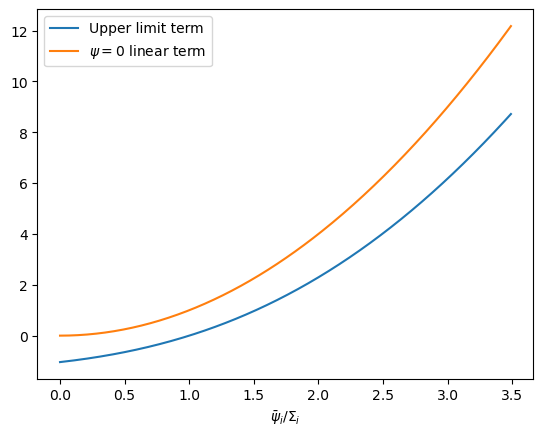

In [4]:
from scipy.special import erfc

pssigax = np.arange(0., 3.5, 0.01)
uplim_term = -2. * np.log(erfc((pssigax - 1.) / np.sqrt(2.)))
lin_term = pssigax**2

plt.plot(pssigax, uplim_term, label='Upper limit term')
plt.plot(pssigax, lin_term, label='$\psi=0$ linear term')
plt.xlabel('$\\bar{\psi}_i / \Sigma_i$')
plt.legend(loc='best')

These curves have similar shapes. It might appear notable that the "upper limit" curve is negative for $\bar{\psi}_i < \Sigma_i$, but the sign doesn't have any intrinsic meaning (remember that we freely dropped additive constants). Shifting them to have the same point at the origin:

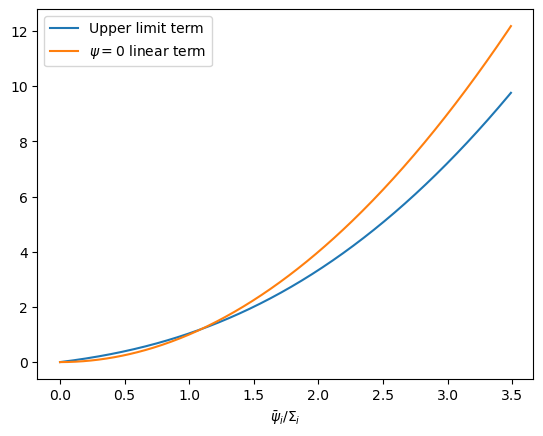

In [5]:
pssigax = np.arange(0., 3.5, 0.01)
uplim_term = -2. * np.log(erfc((pssigax - 1.) / np.sqrt(2.)))
uplim_term -= uplim_term[0]
lin_term = pssigax**2

plt.plot(pssigax, uplim_term, label='Upper limit term')
plt.plot(pssigax, lin_term, label='$\psi=0$ linear term')
plt.xlabel('$\\bar{\psi}_i / \Sigma_i$')
plt.legend(loc='best')

The similarity is now more apparent. However, it is clear that when the model ought to be "many sigma detectable" (on the right), this derivation is more sympathetic to there being an upper limit than a linear fit with a measured value of exactly zero would be. This is because the Gaussian drops so dramatically in the tails, and so the difference between $\psi_i=0$ (the only possibility for the linear term) and $\psi_i=\Sigma_i$ (allowed in the upper limit term) is significant.

## Alternative procedure: log when possible, linear when negative

The upper limit term is a little long to calculate and definitely more painful to treat analytically if that's useful, so another approach might be to use the log fit wherever it's not negative, and do a linear term instead of the upper limit term when it's negative. As we'll see below, this relatively simple modification actually performs great. Formally, it still looks like very much like least squares; we minimize

$$ \sum_{i\textrm{ where }\psi_i>0} \frac{(y_i - \bar{y}_i)^2}{\sigma_i^2} + \sum_{i\textrm{ where }\psi_i \le 0} \frac{(\psi_i - \bar{\psi}_i)^2}{\Sigma_i^2} $$
with respect to the model parameters, where again $\{\psi_i\}$, $\{\Sigma_i\}$ are the raw (linear, background-subtracted) values and their uncertainties, $ \{y_i = \log_{10}(\psi_i)\} $, 
$ \{\sigma_i = \Sigma_i / \psi_i \ln(10)\}$ are the log-transformed values, and $\bar{\psi}_i$ and $\bar{y}_i$ are the model predictions for $\psi_i$ and $y_i$ respectively.

## Bias

On BlueSky, Heloise Stevance (@sydonahi.bsky.social) suggested adding a bias to both the data points and the model to bring all points positive before doing the fitting in log space. In other words, if we add a bias $b$ where $b > |\min(\psi_i)|$ we transform the points as
$$ y'_i = \log_{10}(\psi_i + b) $$
$$ \bar{y}'_i = \log_{10}(\bar{\psi}_i + b) $$
$$ \sigma'_i = \frac{\Sigma_i}{(\psi_i+b) \ln 10} $$

Then we can do the original least squares fitting using $y'_i$, $\bar{y}'_i$, and $\sigma'_i$ -- the bias shifts both the data points and model equally. Note, however, that both $y_i-\bar{y}_i$ and $\sigma_i$ change, and in particular the relative errors $\sigma_i$ will be fairly sensitive to the value of $b$ when $|\psi|/b$ is not large.

## Test case

The reason I'm bothering doing this derivation came up in a case where we are fitting a broken exponential model to background-subtracted data with noise. The model is

$$ f(R) = \begin{cases}
  A \exp(- R / a) & R \le R_0 \\
  A \exp[-R_0/a - (R-R_0)/b] & R > R_0\\
\end{cases}$$

with 4 free parameters: the inner and outer scale lengths $a$ and $b$, the break radius $R_0$, and the amplitude $A$. On a log-linear scale, this is a typical situation:

In [6]:
def broken_exponential(R, parms):
    A, a, b, R0 = parms
    inner_mask = (R <= R0)
    outer_mask = (R > R0)
    inner_values = A * np.exp(-R/a)
    outer_values = A * np.exp(-R0/a - (R-R0)/b)
    model = inner_mask*inner_values + outer_mask*outer_values
    return model

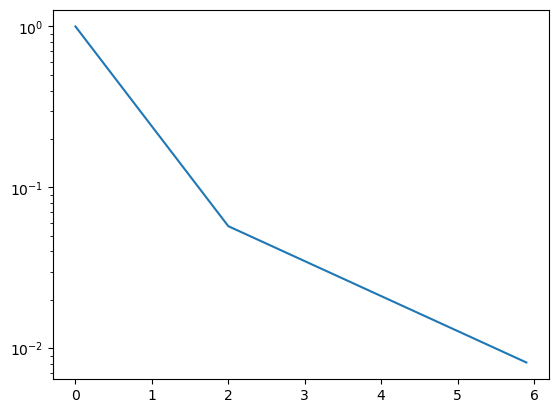

In [7]:
A_true = 1.
a_true = 0.7
b_true=2.
R0_true = 2.
trueparms = np.array([A_true, a_true, b_true, R0_true])

rax = np.arange(0,6,0.1)
plt.plot(rax, broken_exponential(rax, trueparms))
plt.yscale('log')

Now let's create some data. I'll add a small constant across the board, add noise proportional to the new value, and then subtract the background again.

In [8]:
Ndata = 50
bg = 3e-2  # background level
noise_ratio = 0.3 # 30% errors
rng = np.random.default_rng(1)
Rdata = rng.uniform(low=0., high=6., size=Ndata)
underlying_true = broken_exponential(Rdata, trueparms)
underlying_with_bg = underlying_true + bg
sigmadata = noise_ratio * underlying_with_bg
valuedata = rng.normal(loc=underlying_with_bg, scale=sigmadata, size=Ndata) - bg

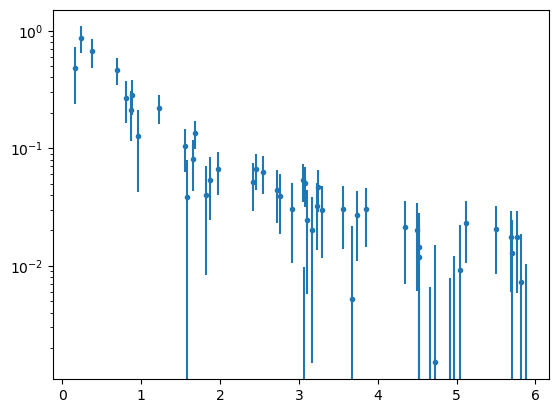

In [9]:
plt.errorbar(Rdata, valuedata, sigmadata, fmt='.')
plt.yscale('log')

In [10]:
np.where(valuedata < 0.)

(array([ 6, 23, 33, 46, 49]),)

With these parameters, about 10% of the data points are negative -- enough that it could have an impact.

### Test 1: Linear fit

We're going to use ```scipy.optimize.minimize``` throughout.

In [11]:
from scipy.optimize import minimize

In [12]:
guess = trueparms + rng.uniform(low=-2, high=2, size=4)
print('True:', trueparms)
print('Initial guess:',guess)

True: [1.  0.7 2.  2. ]
Initial guess: [1.61546404 0.424907   3.46928202 2.52854047]


In [13]:
def sumsquares(parms, R, y, sigma):
    ss = ((y-broken_exponential(R,parms)) / sigma)**2
    return np.sum(ss)

In [14]:
small = 1e-7
linfit_results = minimize(sumsquares, guess, args=(Rdata,valuedata,sigmadata), \
                         bounds=((small,None),(None,None),(None,None),(small,None)) )
linfit_results

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 33.27617051198573
        x: [ 9.653e-01  6.849e-01  1.751e+00  1.819e+00]
      nit: 34
      jac: [ 3.560e-04  2.674e-03  4.846e-04 -6.126e-01]
     nfev: 390
     njev: 78
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>

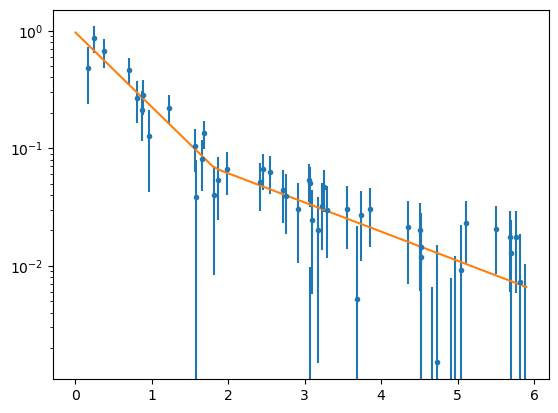

In [15]:
plt.errorbar(Rdata, valuedata, sigmadata, fmt='.')
plt.plot(rax, broken_exponential(rax, linfit_results.x))
plt.yscale('log')

In [16]:
print(f'True: {trueparms}')
print(f'Fit: {linfit_results.x}')

True: [1.  0.7 2.  2. ]
Fit: [0.96529334 0.68488464 1.75129484 1.81916895]


Summary: Does a good job on the inner part, break radius is somewhat small and the outer slope is definitely short.

### Test 2: Log fit ignoring negative points

In [17]:
valuedata_log = np.log10(valuedata)
sigmadata_log = sigmadata / (valuedata * np.log(10))
positivep = (valuedata > 0.)

/var/folders/nv/wnbn9lg96q763fz6ndnnnpt40000gq/T/ipykernel_90795/2062580544.py:1: RuntimeWarning: invalid value encountered in log10
  valuedata_log = np.log10(valuedata)


In [18]:
def sumlogsquares(parms, R, y, sigma):
    ss = ((y-np.log10(broken_exponential(R,parms))) / sigma)**2
    return np.sum(ss)

In [19]:
logfit_results = minimize(sumlogsquares, guess, args=(Rdata[positivep],valuedata_log[positivep],sigmadata_log[positivep]), \
                         bounds=( (small,None),(None,None),(None,None),(small,None) ) )
logfit_results

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 14.324623894190887
        x: [ 1.064e+00  6.996e-01  2.414e+00  1.911e+00]
      nit: 28
      jac: [ 4.174e-05  3.286e-05  4.441e-06 -5.684e-06]
     nfev: 205
     njev: 41
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>

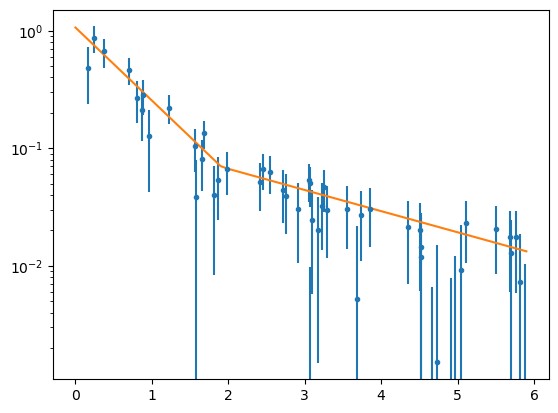

In [20]:
plt.errorbar(Rdata, valuedata, sigmadata, fmt='.')
plt.plot(rax, broken_exponential(rax, logfit_results.x))
plt.yscale('log')

In [21]:
print(f'True: {trueparms}')
print(f'Fit: {logfit_results.x}')

True: [1.  0.7 2.  2. ]
Fit: [1.06377183 0.69960074 2.414167   1.91123236]


Inner part is even better, break radius is slightly better, outer slope is actually large by more than it used to be short.

### Test 3: Upper limit term

In [22]:
def sum_uplimterm(parms, R, y, sigma):
    pssig = broken_exponential(R,parms) / sigma
    VLARGE = 1e7
    erfterm = erfc((pssig - 1.) / np.sqrt(2.))
    toobigp = (erfterm == 0.)
    uls = -2. * np.log(erfterm)
    uls[toobigp] = VLARGE
    return np.sum(uls)

def sum_ulsscombi(parms, R, y, sigma):
    positivep = (y > 0.)
    uplimp = (y <= 0.)

    logy = np.log10(y[positivep])
    logsigma = sigma[positivep] / (y[positivep] * np.log(10))

    ss = sumlogsquares(parms, R[positivep], logy, logsigma)
    uls = sum_uplimterm(parms, R[uplimp], y[uplimp], sigma[uplimp])
    return ss + uls

In [23]:
upfit_results = minimize(sum_ulsscombi, guess, args=(Rdata,valuedata,sigmadata), \
                         bounds=( (small,None),(None,None),(None,None),(small,None) ) )
upfit_results

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 19.541365585287167
        x: [ 1.064e+00  6.996e-01  2.085e+00  1.900e+00]
      nit: 31
      jac: [ 7.780e-05  1.819e-04 -3.695e-05  9.699e-05]
     nfev: 185
     njev: 37
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>

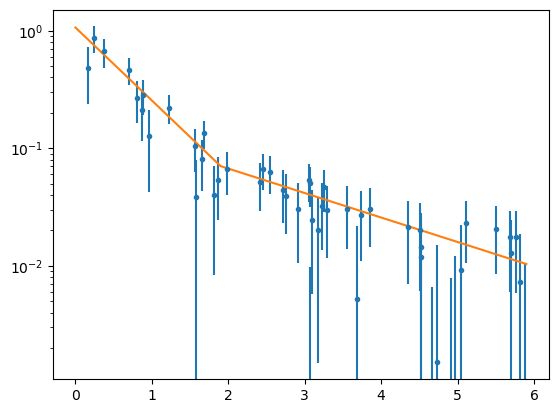

In [24]:
plt.errorbar(Rdata, valuedata, sigmadata, fmt='.')
plt.plot(rax, broken_exponential(rax, upfit_results.x))
plt.yscale('log')

In [25]:
print(f'True: {trueparms}')
print(f'Fit: {upfit_results.x}')

True: [1.  0.7 2.  2. ]
Fit: [1.06377039 0.69960177 2.08535693 1.89951091]


Even better! Inner part is almost perfect, break radius is equivalent to log version, outer slope is by far the best.

### Test 4: Log where possible, linear when negative


In [26]:
def sum_loglincombi(parms, R, y, sigma):
    positivep = (y > 0.)
    uplimp = (y <= 0.)

    logy = np.log10(y[positivep])
    logsigma = sigma[positivep] / (y[positivep] * np.log(10))

    logs = sumlogsquares(parms, R[positivep], logy, logsigma)
    lins = sumsquares(parms, R[uplimp], y[uplimp], sigma[uplimp])
    return logs+lins

In [27]:
loglinfit_results = minimize(sum_loglincombi, guess, args=(Rdata,valuedata,sigmadata), \
                         bounds=( (small,None),(None,None),(None,None),(small,None) ) )
loglinfit_results

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 30.995764579410178
        x: [ 1.064e+00  6.996e-01  1.993e+00  1.905e+00]
      nit: 33
      jac: [-2.522e-05 -2.132e-06  1.563e-05 -3.446e-05]
     nfev: 195
     njev: 39
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>

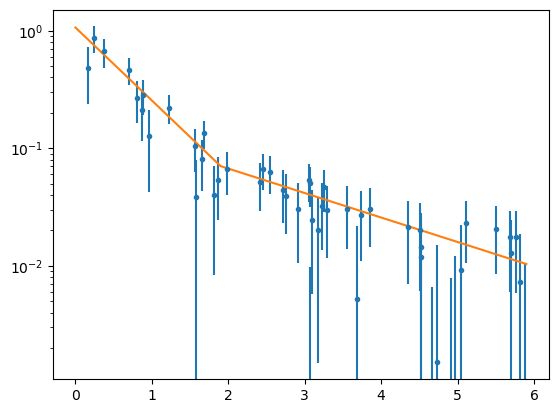

In [28]:
plt.errorbar(Rdata, valuedata, sigmadata, fmt='.')
plt.plot(rax, broken_exponential(rax, upfit_results.x))
plt.yscale('log')

In [29]:
print(f'True: {trueparms}')
print(f'Fit: {loglinfit_results.x}')

True: [1.  0.7 2.  2. ]
Fit: [1.06377108 0.69960087 1.99338365 1.90490039]


This is the best, for sure -- as good as the upper limit for the break and inner part, and almost nails the outer part perfectly.

### Test 5: Bias

Because the bias fits are likely to depend on the value of the bias, we'll need to try a few different values. We'll quantify it in terms of $\frac{b}{|\min(\psi_i)|}$ which must be $>1$ to make all negative data points positive.

In [30]:
def sumlogsquares_bias(parms, R, psi, Sigma, bias):
    psi_bias = psi + bias
    sigma_bias = Sigma / (psi_bias * np.log(10))
    ss = ((np.log10(psi_bias)-np.log10(broken_exponential(R,parms)+bias)) / sigma_bias)**2
    return np.sum(ss)

In [31]:
biasratio = 1.2
bias = biasratio * np.abs(np.min(valuedata))
bias12fit_results = minimize(sumlogsquares_bias, guess, args=(Rdata,valuedata,sigmadata,bias), \
                         bounds=( (small,None),(None,None),(None,None),(small,None) ) )
bias12fit_results

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 18.62868486687422
        x: [ 1.063e+00  6.944e-01  2.168e+00  1.871e+00]
      nit: 29
      jac: [-3.623e-01 -7.258e-02  7.504e-02 -1.381e-01]
     nfev: 430
     njev: 86
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>

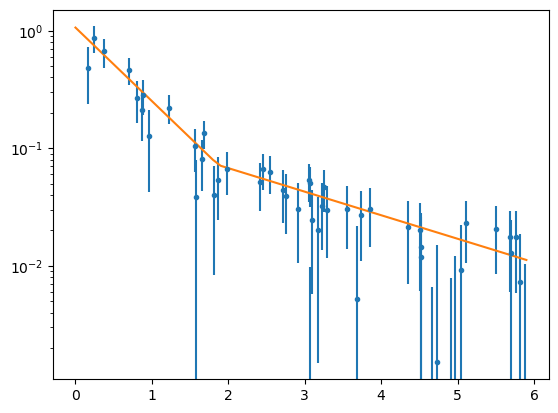

In [32]:
plt.errorbar(Rdata, valuedata, sigmadata, fmt='.')
plt.plot(rax, broken_exponential(rax, bias12fit_results.x))
plt.yscale('log')

In [33]:
print(f'True: {trueparms}')
print(f'Fit: {bias12fit_results.x}')

True: [1.  0.7 2.  2. ]
Fit: [1.0633071  0.694375   2.16770573 1.87098871]


Not bad - similar to the upper limit term but slightly worse. How about a different bias ratio?

In [34]:
biasratio = 2.0
bias = biasratio * np.abs(np.min(valuedata))
bias20fit_results = minimize(sumlogsquares_bias, guess, args=(Rdata,valuedata,sigmadata,bias), \
                         bounds=( (small,None),(None,None),(None,None),(small,None) ) )
bias20fit_results

  message: ABNORMAL_TERMINATION_IN_LNSRCH
  success: False
   status: 2
      fun: 21.556226609647357
        x: [ 1.064e+00  6.943e-01  2.060e+00  1.871e+00]
      nit: 38
      jac: [-1.954e-05  1.485e-04 -1.670e-05  9.059e-01]
     nfev: 530
     njev: 106
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>

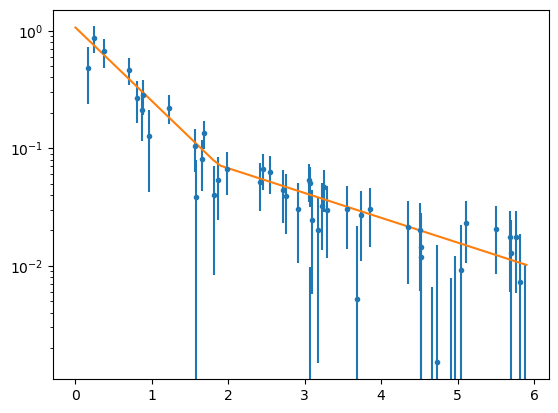

In [35]:
plt.errorbar(Rdata, valuedata, sigmadata, fmt='.')
plt.plot(rax, broken_exponential(rax, bias20fit_results.x))
plt.yscale('log')

In [36]:
print(f'True: {trueparms}')
print(f'Fit: {bias20fit_results.x}')

True: [1.  0.7 2.  2. ]
Fit: [1.06426452 0.69429758 2.06016368 1.87098871]


Very similar to the lower bias but slightly better outer scale length. How about even more bias?

In [37]:
biasratio = 3.0
bias = biasratio * np.abs(np.min(valuedata))
bias30fit_results = minimize(sumlogsquares_bias, guess, args=(Rdata,valuedata,sigmadata,bias), \
                         bounds=( (small,None),(None,None),(None,None),(small,None) ) )
bias30fit_results

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 23.956724221854238
        x: [ 1.062e+00  6.941e-01  1.978e+00  1.871e+00]
      nit: 29
      jac: [ 1.719e-01  3.255e-01  5.381e-03  1.796e-01]
     nfev: 370
     njev: 74
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>

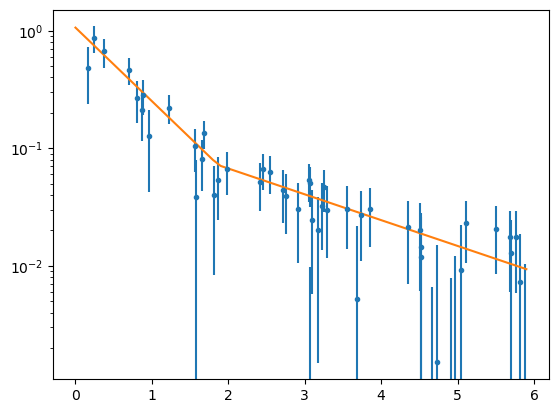

In [38]:
plt.errorbar(Rdata, valuedata, sigmadata, fmt='.')
plt.plot(rax, broken_exponential(rax, bias30fit_results.x))
plt.yscale('log')

In [39]:
print(f'True: {trueparms}')
print(f'Fit: {bias30fit_results.x}')

True: [1.  0.7 2.  2. ]
Fit: [1.06237162 0.69414431 1.97754289 1.8709887 ]


Again, similar but slightly better on the outer scale length.

## Comparison

In [40]:
lin_x = 0.
log_x = 1.
ul_x = 2.
ll_x = 3.
b12_x = 4.
b20_x = 5.
b30_x = 6.
dx = 0.05
colors = ['red','blue','green','black']

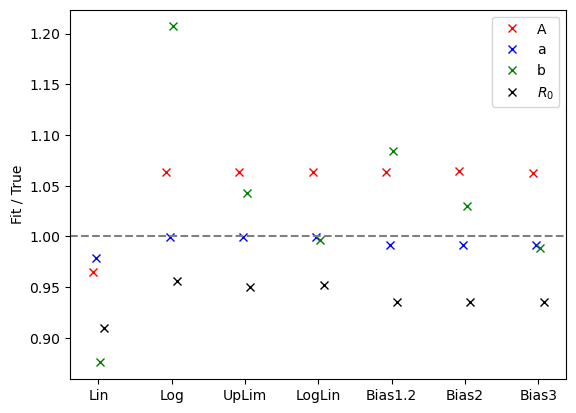

In [44]:
for (x, fit) in zip([lin_x,log_x,ul_x,ll_x,b12_x,b20_x,b30_x], [linfit_results, logfit_results, upfit_results, loglinfit_results, \
                                                               bias12fit_results, bias20fit_results, bias30fit_results]):
    if x==0.:
        labels = ['A','a','b','$R_0$']
    else:
        labels = [None,None,None,None]
        
    for i in range(4):
        plt.plot(x + i*dx, (fit.x/trueparms)[i], 'x', color=colors[i], label=labels[i])
plt.axhline(y=1., color='gray', linestyle='dashed')

plt.xticks(np.arange(7)+1.5*dx, ['Lin','Log','UpLim','LogLin','Bias1.2','Bias2','Bias3'])
plt.ylabel('Fit / True')
plt.legend(loc='best')

Clearly, at least in this case, the LogLin procedure -- using least squares with log values when possible and linear values otherwise -- performs the best, followed by using the upper limit term, while pure linear and pure log least squares are not recommended. Using a bias has about a similar level of accuracy ($a$ and $R_0$ are slightly worse) but, as expected, the answer has a strong dependence on the magnitude of the bias, which is a free parameter and the best option will likely depend on the actual functional form and size of the error bars.

A more formal analysis would re-do this for many different random seeds, which would better quantify the error and help understand how much is scatter vs. bias, as well as checking how it performs as a function of how many negative values there are. If anyone does this, I would love to hear the results! (jbailin at ua dot edu).